# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )
print("Data shape: ", holdout_data.shape)

Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



**Convert all attributes to numeric**

In [7]:
data = data.apply(pd.to_numeric, errors="coerce")

**Split the data**

We will exclude the attribute of Id because the random number does not help us predict the bankruptcy. 

In [8]:
from sklearn.model_selection import train_test_split

X = data.loc[:,"X1":"X64"]
y = data.loc[:,"Bankrupt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

**Evaluation metrics**

Before trying different models, we write our functions of evaluation metrics. This evaluation metrics represents the performance of our models and will be used to select our best model.

In [9]:
from sklearn.metrics import accuracy_score,recall_score,precision_score

# Define the in-sample evaluation metrics
def in_sample_scores(train,predict):
    accuracy_in_sample = accuracy_score(train, predict)
    recall_in_sample = recall_score(train, predict, pos_label=1, average="binary")
    precision_in_sample = precision_score(train, predict, pos_label=1, average="binary")

    print("\t{m:s} in sample Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format
                                                                           (m=name,
                                                                            a=accuracy_in_sample,
                                                                            r=recall_in_sample,
                                                                            p=precision_in_sample))

In [10]:
# Define the out-of-sample evaluation metrics
def out_of_sample_scores(test,predict):
    accuracy_test = accuracy_score(test, predict)
    recall_test = recall_score(test, predict, pos_label=1, average="binary")
    precision_test = precision_score(test, predict, pos_label=1, average="binary")

    print("\t{m:s} out of sample Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test))

**Logistic Regression**

We start with the logistic regression model.

We create a model pipeline that fills in all missing values with their median, scales and normalizes the data, and uses logistic regression as classifier.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

In [12]:
# Create the pipeline
scaler = StandardScaler()
logistic_clf = LogisticRegression(solver ="liblinear",random_state=42)
name = "Logistic"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("classifier",logistic_clf)])

# Fit the model
model_pipeline.fit(X_train,y_train)
y_train_predict = model_pipeline.predict(X_train)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train, y_train_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

	Logistic in sample Accuracy: 94.0%, Recall 11.7%, Precision 60.0%


In [13]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Logistic out of sample Accuracy: 92.9%, Recall 7.7%, Precision 57.1%


*Logistic Regression*: The overall accuracy is good, but the recall and precision are not as expected. Possible reason might be the imbalanced data.

**Deal with the imbalanced data**

Over-sampling: We will generate new samples in the class of Bankrupt == 1 which is under-represented.

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

**Logistic Regression on balanced data**

We then try the logistic regression model on the balanced data.

In [15]:
# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

	Logistic in sample Accuracy: 79.8%, Recall 77.2%, Precision 81.4%


In [16]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Logistic out of sample Accuracy: 81.6%, Recall 65.4%, Precision 22.8%


We can also try to use the class_weight parameter in the logistic regression function to deal with the imbalance.

In [17]:
# Create the pipeline
scaler = StandardScaler()
logistic_clf = LogisticRegression(solver ="liblinear",class_weight="balanced",random_state=42)
name = "Logistic"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("classifier",logistic_clf)])

# Fit the model
model_pipeline.fit(X_train,y_train)
y_train_predict = model_pipeline.predict(X_train)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train, y_train_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

	Logistic in sample Accuracy: 82.3%, Recall 76.2%, Precision 22.7%


In [18]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Logistic out of sample Accuracy: 81.1%, Recall 65.4%, Precision 22.2%


*Logistic Regression on balanced data*: Both balancing methods yield similar results. We will use the former balancing method in the later notebook since it would work on all models consistently. Compared with the model with imbalanced data, both in-sample and out-of-sample recall get much better.

**Principal Component Analysis**

Now let's try PCA and see if it can improve model performance.

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=64))])

Text(0.5, 0, '# of components')

Text(0, 0.5, 'cumulative variance explained')

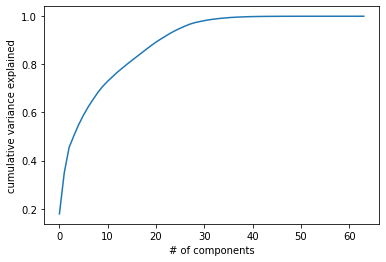

To explain 80.0 % of Variance, we need 15 component


In [19]:
from sklearn.decomposition import PCA

# Find the best hyperparameter of n_components
# Train PCA
scaler = StandardScaler()
pca = PCA(n_components = X_train_balanced.shape[1])
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("pca", pca)])
model_pipeline.fit(X_train_balanced)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.plot(cumsum)
plt.xlabel("# of components")
plt.ylabel("cumulative variance explained")
plt.show()

# Pick the proper n_components for given percentage
percentage = 0.8
cumsum = pd.DataFrame(data = cumsum)
n = cumsum.loc[cumsum[0]>=percentage].index[0] + 1
print("To explain", percentage*100,"% of Variance, we need", n, "component" )

**Logistic Regression with PCA on balanced data**

We now try the logistic regression with PCA on the balanced data.

In [20]:
# Create the pipeline
scaler = StandardScaler()
pca = PCA(n_components=15)
logistic_clf = LogisticRegression(solver ="liblinear",random_state=42)
name = "Logistic"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("pca", pca),("classifier",logistic_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

	Logistic in sample Accuracy: 76.6%, Recall 72.5%, Precision 79.0%


In [21]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Logistic out of sample Accuracy: 78.7%, Recall 65.4%, Precision 20.0%


*Logistic Regression with PCA on balanced data*: The results are slightly worse than that without the PCA.

**Decision Tree**

Now let's use a different model to check if balanced data and PCA would help.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Use Cross-validation to tune the hyperparameter of max_depth
for i in range (4,9):
    tree_clf = DecisionTreeClassifier(max_depth=i,random_state=42)
    model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",tree_clf)])
    cross_val_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5)
    print("For max_depth = ", i , " ,score = ",cross_val_scores.mean())

For max_depth =  4  ,score =  0.9396825396825397
For max_depth =  5  ,score =  0.9391941391941392
For max_depth =  6  ,score =  0.9409035409035409
For max_depth =  7  ,score =  0.936996336996337
For max_depth =  8  ,score =  0.9374847374847375


Therefore, we choose max_depth=6 as our hyperparameter.

Also, decision tree does not require feature scaling to be performed as it is not sensitive to the variance in the data. We only need to transform the missing data to its median.

In [23]:
# Create the pipeline
tree_clf = DecisionTreeClassifier(max_depth=6,random_state=42)
name = "Tree"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",tree_clf)])

# Fit the model
model_pipeline.fit(X_train,y_train)
y_train_predict = model_pipeline.predict(X_train)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train, y_train_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

	Tree in sample Accuracy: 96.6%, Recall 47.3%, Precision 95.3%


In [24]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Tree out of sample Accuracy: 93.8%, Recall 32.7%, Precision 63.0%


*Decision Tree*: Both in-sample and out-of-sample accuracy and precision are good. If the recall can get better, this model would be very good.

**Decision Tree on balanced data**

In [25]:
# Use Cross-validation to tune the hyperparameter of max_depth
for i in range (8,15):
    tree_clf = DecisionTreeClassifier(max_depth=i,random_state=42)
    model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",tree_clf)])
    cross_val_scores = cross_val_score(model_pipeline, X_train_balanced, y_train_balanced, cv=5)
    print("For max_depth = ", i , " ,score = ",cross_val_scores.mean())

For max_depth =  8  ,score =  0.9376130734256243
For max_depth =  9  ,score =  0.9490742908523344
For max_depth =  10  ,score =  0.9589736020629751
For max_depth =  11  ,score =  0.9676990024429968
For max_depth =  12  ,score =  0.9712158150108576
For max_depth =  13  ,score =  0.9718669415038003
For max_depth =  14  ,score =  0.9747322882736157


We choose max_depth=10 as our hyperparameter. Although it does not maximize the validation scores, it prevents over-fitting.

In [26]:
# Create the pipeline
tree_clf = DecisionTreeClassifier(max_depth=10,random_state=42)
name = "Tree"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",tree_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

	Tree in sample Accuracy: 97.8%, Recall 98.7%, Precision 96.9%


In [27]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Tree out of sample Accuracy: 90.7%, Recall 50.0%, Precision 38.8%


*Decision Tree on balanced data*: The in-sample scores are almost perfect. The out-of-sample scores are fair.

**Decision Tree with PCA on balanced data**

In [28]:
# Create the pipeline
pca = PCA(n_components=15)
tree_clf = DecisionTreeClassifier(max_depth=10,random_state=42)
name = "Tree"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("pca", pca),("classifier",tree_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('pca', PCA(n_components=15)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

	Tree in sample Accuracy: 95.4%, Recall 98.9%, Precision 92.4%


In [29]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	Tree out of sample Accuracy: 83.7%, Recall 46.2%, Precision 21.1%


*Decision Tree with PCA on balanced data*: The results are even worse with PCA than that without PCA.

**Discovery**

After comparing the two models on imbalanced/balanced data and with/without PCA, we find that:

1. Balanced data improves performance.
2. PCA does not help.

Thus, we will not use PCA and continue trying new models on balanced data.

**Support Vector Machine on balanced data**

In [30]:
from sklearn.svm import SVC

# Create the pipeline
scaler = StandardScaler()
svm_clf = SVC(kernel="linear")
name = "SVM"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("classifier",svm_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(kernel='linear'))])

	SVM in sample Accuracy: 80.9%, Recall 76.2%, Precision 84.0%


In [31]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	SVM out of sample Accuracy: 83.1%, Recall 65.4%, Precision 24.6%


*SVM on balanced data*: The performance is fairly good, slightly better than that of logistic regression.

**Naive Bayes on balanced data**

In [32]:
from sklearn.naive_bayes import GaussianNB

# Create the pipeline
gnb_clf = GaussianNB()
name = "NB"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",gnb_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier', GaussianNB())])

	NB in sample Accuracy: 51.8%, Recall 96.7%, Precision 50.9%


In [33]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	NB out of sample Accuracy: 14.5%, Recall 94.2%, Precision 7.4%


*Naive Bayed on balanced data*: Although the recall is particularly high, the other results are poor.

**Random Forest on balanced data**

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Use Cross-validation to tune the hyperparameter of n_estimators
for i in range (10,120,15):
    forest_clf = RandomForestClassifier(n_estimators=i,random_state=42)
    model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",forest_clf)])
    cross_val_scores = cross_val_score(model_pipeline, X_train_balanced, y_train_balanced, cv=5)
    print("For n_estimators = ", i , " ,score = ",cross_val_scores.mean())

For n_estimators =  10  ,score =  0.9934878868078176
For n_estimators =  25  ,score =  0.9911438823289902
For n_estimators =  40  ,score =  0.9915345921552661
For n_estimators =  55  ,score =  0.9914044686482084
For n_estimators =  70  ,score =  0.9919254716340934
For n_estimators =  85  ,score =  0.9914044686482084
For n_estimators =  100  ,score =  0.9917951784744844
For n_estimators =  115  ,score =  0.9915348466340934


The validation scores do not fluctuate much as we change our hyperparameter of n_estimators. Thus we just stick to the default value.

In [35]:
# Use Cross-validation to tune the hyperparameter of max_depth
for i in range (3,10):
    forest_clf = RandomForestClassifier(max_depth=i,random_state=42)
    model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",forest_clf)])
    cross_val_scores = cross_val_score(model_pipeline, X_train_balanced, y_train_balanced, cv=5)
    print("For max_depth = ", i , " ,score = ",cross_val_scores.mean())

For max_depth =  3  ,score =  0.8200048350977198
For max_depth =  4  ,score =  0.8566024531758958
For max_depth =  5  ,score =  0.8851240160152007
For max_depth =  6  ,score =  0.9092199375678611
For max_depth =  7  ,score =  0.9399580958197611
For max_depth =  8  ,score =  0.9591029621335505
For max_depth =  9  ,score =  0.9708256989685126


We noticed from above that increasing a unit number of max_depth increases the validation score around 2%. However, to avoid overfitting, we choose max_depth=4 as our hyperparameter.

In [36]:
# Create the pipeline
forest_clf = RandomForestClassifier(max_depth=4,random_state=42)
name = "forest"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),("classifier",forest_clf)])

# Fit the model
model_pipeline.fit(X_train_balanced,y_train_balanced)
y_train_balanced_predict = model_pipeline.predict(X_train_balanced)

# Compute the in-sample evaluation metrics
in_sample_scores(y_train_balanced, y_train_balanced_predict)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 RandomForestClassifier(max_depth=4, random_state=42))])

	forest in sample Accuracy: 86.3%, Recall 83.6%, Precision 88.4%


In [37]:
# Compute the out-of-sample evaluation metrics
y_test_predict = model_pipeline.predict(X_test)
out_of_sample_scores(y_test,y_test_predict)

	forest out of sample Accuracy: 85.2%, Recall 63.5%, Precision 27.3%


*Random Forest on balanced data*: The results are similar to that of SVM. However, the selection of hyperparameters was quite arbitrary.

**Choose the best model**

Our evaluation metrics contains accuracy, recall, and precision. All of them refer to out-of-sample scores.

Since our data is highly imbalanced, accuracy is not a proper measure.

Recall is the amount of true positives devided by the amount that true states are positive, which in context is the number of companies that being correctly labeled as Bankrupt devided by the total number of companies that truly go bankrupt.

Precision if the amount of true positives devided by the amount that the predictions are positive, which in context is the number of companies that being correctly labeled as Bankrupt devided by the total number of companies that being labeled as Bankrupt.

Since there is a trade-off between recall and precision, and it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt, recall is 5 times important than precision.

Based on balanced data and without PCA, we have five models in total. We rank them from worst to best as follows:

- No.5 Naive Bayes
    - The accuracy and precision are very low, so we rank it as the last.
    

- No.4 Decision Tree
    - The accuracy and precision are about 10% higher than that of top 3 models, but the recall is about 10% lower than that of top 3 models. Since recall is 5 times important than precision, we rank Decision Tree behind the top 3 models.


- No.3 Logistic Regression
    - All scores are a little lower than that of SVM model, so we rank it as No.3.


- No.2 Random Forest
    - The scores of Random Forest and SVM are similar. Random Forest's accuracy and precision are slightly better than that of SVM, while SVM's recall is slightly better than that of Random Forest. However, the result of Random Forest is highly depend on the hyperparameters. It is unsure that the parameters we chose for our training data will perform well on the hold_out data, so we rank it behind the SVM model.
    

- No.1 Support Vector Machine
    - The left one as the result of the elimination process.

**Fit the chosen model to the whole data**

In [38]:
# Balance the data
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

# Create the pipeline:
scaler = StandardScaler()
svm_clf = SVC(kernel="linear")
name = "SVM"
model_pipeline = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                 ("scaler",scaler),("classifier",svm_clf)])

# Fit the model
model_pipeline.fit(X_balanced,y_balanced)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(kernel='linear'))])

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [39]:
import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    
    # Convert all attributes to numeric
    X = X.apply(pd.to_numeric, errors="coerce")
    
    # Remove the attribute of Id
    X = X.loc[:,"X1":"X64"]
   
    # Use the fitted model to predict on X
    predictions = model_pipeline.predict(X)
    
    
    return predictions

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [40]:
name = "SVM"
y_test_pred = MyModel(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	SVM Accuracy: 79.4%, Recall 71.2%, Precision 21.6%
